# Galaxy Classifiers (Spiral, Elliptical, Odd objects)

**Most of this code is made by the authors of the paper of Ghaderi et al. (2025) (https://iopscience.iop.org/article/10.3847/1538-4365/ada8ab) and taken from the GitHub Repository: https://github.com/hmddev1/machine_learning_for_morphological_galaxy_classification**

**This notebook classifies the images of galaxies to spiral and elliptical galaxies and odd objects.**

In this notebook, we use the models from Ghaderi et al. (2025), using different thresholds for the dataset (see sections 2 and 4.3 of the report). The purpose of this notebook is to train the models on data that has lowered thresholds (a worse "quality" data) and to test the models on the galaxies with the original thresholds presented in Ghaderi et al. (2025). The dataset is Galaxy Zoo 2 [Hart et al. (2016), Willett et al. (2013)]. We do this only for galaxies (no stars and no artifacts). We use the following thresholds:

Whether the object is a galaxy or not:
+ t01_smooth_or_features_a03_star_or_artifact_fraction < 0.5

Whether the object presents the characteristics of a spiral galaxy:

+ 0.90 <= t01_smooth_or_features_a02_features_or_disk_fraction <= 0.95
+ 0.90 <= t02_edgeon_a05_no_fraction <= 0.95
+ 0.90 <= t04_spiral_a08_spiral_fraction <= 0.95

Whether the object presents the characteristics of an elliptical galaxy:

+ 0.85 <= t01_smooth_or_features_a01_smooth_fraction <= 0.90
+ 0.85 <= t07_rounded_a16_completely_round_fraction <= 0.90
+ 0.85 <= t06_odd_a15_no_fraction <= 0.90

Whether the object presents the characteristics for it being an "odd" (irregular, ring, lens, disturbed, merger, dust lane, and other galactic features [Ghaderi et al. 2025]) galaxy:

+ 0.85 <= t06_odd_a14_yes_fraction <= 0.90

In [ ]:
import os
path = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/'
os.chdir(path)
%run imports.py
%matplotlib inline
import plotting
roc_curves = {}

Mounted at /content/drive


Setting up the dataset:

In [ ]:
file_path_columns = "/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/gz2_hart16.csv.gz"
data_columns = pd.read_csv(file_path_columns)
#data_columns.head()

In [ ]:
df_columns = pd.read_csv(file_path_columns, compression='gzip')

#Removing non-galaxy samples
df_galaxies = df_columns[df_columns['t01_smooth_or_features_a03_star_or_artifact_fraction'] < 0.5]

# Apply thresholds for spiral galaxies
spiral_galaxies = df_galaxies[
    (df_galaxies['t01_smooth_or_features_a02_features_or_disk_fraction'] >= 0.90) &
    (df_galaxies['t01_smooth_or_features_a02_features_or_disk_fraction'] <= 0.95) &
    (df_galaxies['t02_edgeon_a05_no_fraction'] >= 0.90) &
    (df_galaxies['t02_edgeon_a05_no_fraction'] <= 0.95) &
    (df_galaxies['t04_spiral_a08_spiral_fraction'] >= 0.90) &
    (df_galaxies['t04_spiral_a08_spiral_fraction'] <= 0.95)
]

# Apply thresholds for elliptical galaxies

elliptical_galaxies = df_galaxies[
    (df_galaxies['t01_smooth_or_features_a01_smooth_fraction'] >= 0.85) &
    (df_galaxies['t01_smooth_or_features_a01_smooth_fraction'] <= 0.90) &
    (df_galaxies['t07_rounded_a16_completely_round_fraction'] >= 0.85) &
    (df_galaxies['t07_rounded_a16_completely_round_fraction'] <= 0.90) &
    (df_galaxies['t06_odd_a15_no_fraction'] >= 0.85) &
    (df_galaxies['t06_odd_a15_no_fraction'] <= 0.90)
]


# Apply thresholds for odd objects
odd_objects = df_galaxies[
    (df_galaxies['t06_odd_a14_yes_fraction'] >= 0.85) &
    (df_galaxies['t06_odd_a14_yes_fraction'] <= 0.90)
]

# Print results
print(f"Total Spiral Galaxies: {len(spiral_galaxies)}")
print(f"Total Elliptical Galaxies: {len(elliptical_galaxies)}")
print(f"Total Odd Objects: {len(odd_objects)}")

Total Spiral Galaxies: 196
Total Elliptical Galaxies: 374
Total Odd Objects: 1626


In [ ]:
# File name mapping

file_path_map = "/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/gz2_filename_mapping.csv"
data_map = pd.read_csv(file_path_map)
#data_map.head()

Since we have issues with using too much memory when testing the architectures for more than 6000 galaxies, we slice the lists accordingly, while keeping the same ratios per class as the original dataset.

In [ ]:
#Extraction with these thresholds has been completed, so this cell is commented out.

# Paths to images and output folder
zip_path = "/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Datazipped/images_gz2.zip"
output_folder = "/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90"

#spiral_folder = os.path.join(output_folder, 'spiral')
#elliptical_folder = os.path.join(output_folder, 'elliptical')
#odd_folder = os.path.join(output_folder, 'odd')

# os.makedirs(spiral_folder, exist_ok=True)
# os.makedirs(elliptical_folder, exist_ok=True)
# os.makedirs(odd_folder, exist_ok=True)

# # Read the asset_id mapping
# file_path_map = "/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/gz2_filename_mapping.csv"
# data_map = pd.read_csv(file_path_map)

# # Ensure data columns are correctly named
# if 'objid' not in data_map.columns or 'asset_id' not in data_map.columns:
#     raise ValueError("Missing required columns: 'objid' or 'asset_id'")

# # Limit to 3137 spiral, 2083 elliptical, and 781 odd galaxies (total of approx. 6000 galaxies while keeping the same ratios)
# spiral_galaxies = spiral_galaxies.sample(n=3137, random_state=42) if len(spiral_galaxies) > 3137 else spiral_galaxies
# elliptical_galaxies = elliptical_galaxies.sample(n=2083, random_state=42) if len(elliptical_galaxies) > 2083 else elliptical_galaxies
# odd_objects = odd_objects.sample(n=781, random_state=42) if len(odd_objects) > 781 else odd_objects

# # Function to extract images using asset_id for filenames (with progress bar)
# def extract_images(df, class_folder):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         # Merge the data to get the asset_id for the corresponding dr7objid
#         merged_df = df.merge(data_map[['objid', 'asset_id']], left_on='dr7objid', right_on='objid', how='left')

#         if merged_df['asset_id'].isnull().any():
#             print("Warning: Some dr7objid values are missing asset_id mappings")

#         image_names = [f"images/{int(asset_id)}.jpg" for asset_id in merged_df['asset_id'].dropna()]

#         for image_name in tqdm(image_names, desc=f"Extracting images to {class_folder}", unit="image"):
#             if image_name in zip_ref.namelist():
#                 zip_ref.extract(image_name, output_folder)
#                 shutil.move(os.path.join(output_folder, image_name), class_folder)
#             else:
#                 print(f"Image not found: {image_name}")

# extract_images(spiral_galaxies, spiral_folder)
# extract_images(elliptical_galaxies, elliptical_folder)
# extract_images(odd_objects, odd_folder)

In [ ]:
spiral_folder = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90/spiral'
elliptical_folder = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90/elliptical'
odd_folder = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90/odd'


def count_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Spiral Galaxies: {count_files(spiral_folder)} images")
print(f"Elliptical Galaxies: {count_files(elliptical_folder)} images")
print(f"Odd Objects: {count_files(odd_folder)} images")

Spiral Galaxies: 196 images
Elliptical Galaxies: 374 images
Odd Objects: 781 images


We modify the original cropping images algorithm, since it did not perform well for galaxies with more objects in the background (this is due to the lower thresholds used). This new algorithm assumes that the largest object is the galaxy to be classified. We commented this cell out since our data has been processed, but left it here for reproducibility.

In [ ]:
# def find_largest_object(binary_mask):
#     """Find the largest connected component in the binary mask."""
#     labeled = label(binary_mask)
#     regions = regionprops(labeled)

#     if not regions:
#         return binary_mask  # Return as-is if no objects detected

#     largest_region = max(regions, key=lambda r: r.area)
#     mask = np.zeros_like(binary_mask)
#     mask[tuple(largest_region.coords.T)] = 1
#     return mask

# def segment_galaxy(img):
#     """Segment the main galaxy using thresholding and morphological operations."""
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Adaptive thresholding to remove background noise
#     _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # Morphological operations to clean noise
#     kernel = np.ones((5, 5), np.uint8)
#     opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

#     # Find the largest bright object (assumed to be the galaxy)
#     mask = find_largest_object(opened)
#     return mask

# def crop_galaxy(img, mask):
#     """Extract the bounding box of the detected galaxy and resize it."""
#     y_indices, x_indices = np.where(mask > 0)

#     if len(x_indices) == 0 or len(y_indices) == 0:
#         return None  # No valid segmentation

#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_indices), np.max(y_indices)

#     # Add padding
#     pad = 20
#     x_min, x_max = max(x_min - pad, 0), min(x_max + pad, img.shape[1])
#     y_min, y_max = max(y_min - pad, 0), min(y_max + pad, img.shape[0])

#     cropped = img[y_min:y_max, x_min:x_max]

#     # Resize to standard dimensions
#     final_size = 256
#     resized = resize(cropped, (final_size, final_size))
#     return resized

In [ ]:
# # Paths to images and output folder
# image_path = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90/spiral'
# cropped_folder = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/spiral_cropped'

# # Create output folder if it doesn't exist
# os.makedirs(cropped_folder, exist_ok=True)

# # Get list of image files
# image_files = [os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.jpg')]
# cropped_image_count = 0

# for img_path in tqdm(image_files, desc="Processing images", unit="image"):
#     img = cv2.imread(img_path)
#     mask = segment_galaxy(img)
#     cropped = crop_galaxy(img, mask)

#     if cropped is not None:
#         # Save the cropped image
#         output_path = os.path.join(cropped_folder, os.path.basename(img_path))
#         cv2.imwrite(output_path, (cropped * 255).astype(np.uint8))
#         cropped_image_count += 1

# print(f"Total number of cropped images: {cropped_image_count}")

In [ ]:
# # Paths to images and output folder
# image_path = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90/elliptical'
# cropped_folder = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/elliptical_cropped'

# # Create output folder if it doesn't exist
# os.makedirs(cropped_folder, exist_ok=True)

# # Get list of image files
# image_files = [os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.jpg')]
# cropped_image_count = 0

# for img_path in tqdm(image_files, desc="Processing images", unit="image"):
#     img = cv2.imread(img_path)
#     mask = segment_galaxy(img)
#     cropped = crop_galaxy(img, mask)

#     if cropped is not None:
#         # Save the cropped image
#         output_path = os.path.join(cropped_folder, os.path.basename(img_path))
#         cv2.imwrite(output_path, (cropped * 255).astype(np.uint8))
#         cropped_image_count += 1

# print(f"Total number of cropped images: {cropped_image_count}")

In [ ]:
# # Paths to images and output folder
# image_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/odd'
# cropped_folder = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/odd_cropped'

# # Create output folder if it doesn't exist
# os.makedirs(cropped_folder, exist_ok=True)

# # Get list of image files
# image_files = [os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.jpg')]
# cropped_image_count = 0

# for img_path in tqdm(image_files, desc="Processing images", unit="image"):
#     img = cv2.imread(img_path)
#     mask = segment_galaxy(img)
#     cropped = crop_galaxy(img, mask)

#     if cropped is not None:
#         # Save the cropped image
#         output_path = os.path.join(cropped_folder, os.path.basename(img_path))
#         cv2.imwrite(output_path, (cropped * 255).astype(np.uint8))
#         cropped_image_count += 1

# print(f"Total number of cropped images: {cropped_image_count}")

## **Models I and II**: Two classifier models based on Zernike Moments (ZMs)

### Compute the ZMs:

##### We will use the [ZEMO](https://pypi.org/project/ZEMO/) python package to compute ZMs for galaxy and non-galaxy images. [This](https://github.com/hmddev1/ZEMO) GitHub repo can be used to compute ZMs for images. This package was described in the research paper [[IAJJ](https://ijaa.du.ac.ir/article_374_ad45803d737b0a7d4fc554a244229df6.pdf)].

*Note: The galaxy and non-galaxy images are in RGB format. Here, we used the R channel of images. The size of original Galaxy Zoo 2 images is (424, 424) pixels, while we resized them to (200, 200) pixels. To compute ZMs we set the maximum order number $P_{max} = 45$.*

In [ ]:
def calculate_zernike_moments(data_dir, image_size, zernike_order):

        ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)

        image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        zernike_moments = []

        #for img_path in image_files:
        for img_path in tqdm(image_files, desc="Processing images", unit="image"):
            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (image_size,image_size))
            im = resized_image[:, :, 0]
            Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
            zernike_moments.append(Z)

        df = pd.DataFrame(zernike_moments)

        return df

- The **Data** files can be downloaded from [this link](https://drive.google.com/file/d/1wxmYQ8qpgaVDuD3kTeBrZlyny0IBA9wn/view?usp=drive_link).

- The directories of Spiral, Elliptical, Odd objects images:

        - Spiral: /repository/Data/galaxy/image/cropped_spiral
        - Elliptical: /repository/Data/galaxy/image/cropped_elliptical
        - Odd objects: /repository/Data/galaxy/image/cropped_odd

Note: this code trains the models on the modified data and tests the models on the original data. This is why some cells are repeated, since we are dealing with 2 different datasets. For simplicity, the code is the same as the other notebook in this folder, but the variable names are switched between datasets!

In [ ]:
# Paths to images
spath_bad = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_spiral'
epath_bad = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_elliptical'
opath_bad = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_odd'

# Default image size and zernike order.
image_size = 200
zernike_order = 45

In [ ]:
# Paths to images
spath = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/spiral_cropped'
epath = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/elliptical_cropped'
opath = r'/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/odd_cropped'

# Default image size and zernike order.
image_size = 200
zernike_order = 45

**Note**: The following cell calculates the Zernike Moments for all the images of all classes (i.e., Spiral Galaxies, Elliptical Galaxies & Odd Objects). This is time consuming so, once again, we have commented this part out and kept it for reproducibility.

In [ ]:
# WARNING: This cell takes a lot of time!

# Calculating Zernike Momens (ZMs)
#spiral_zm_df = calculate_zernike_moments(spath, image_size, zernike_order)
#spiral_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv')
#spiral_zm_df = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv', index_col=0)

#elliptical_zm_df = calculate_zernike_moments(epath, image_size, zernike_order)
#elliptical_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/elliptical_zms.csv')

#odd_zm_df = calculate_zernike_moments(opath, image_size, zernike_order)
#odd_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/odd_zms.csv')

#np.shape(spiral_zm_df), np.shape(elliptical_zm_df), np.shape(odd_zm_df)

In [ ]:
# #for the "bad data":

# # WARNING: This cell takes a lot of time!

# # Calculating Zernike Moments (ZMs)
# spiral_zm_df_bad = calculate_zernike_moments(spath_bad, image_size, zernike_order)
# spiral_zm_df_bad.to_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/spiral_zms.csv')

# elliptical_zm_df_bad = calculate_zernike_moments(epath_bad, image_size, zernike_order)
# elliptical_zm_df_bad.to_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/elliptical_zms.csv')

# odd_zm_df_bad = calculate_zernike_moments(opath_bad, image_size, zernike_order)
# odd_zm_df_bad.to_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/odd_zms.csv')

# np.shape(spiral_zm_df_bad), np.shape(elliptical_zm_df_bad), np.shape(odd_zm_df_bad)

In [ ]:
# Loading the ZMs and concatenating to a consolidated dataset (bad data)
spiral_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/spiral_zms.csv')
elliptical_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/elliptical_zms.csv')
odd_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/ZMs/odd_zms.csv')

spiral_data.drop("Unnamed: 0", axis = 1, inplace = True)
elliptical_data.drop("Unnamed: 0", axis = 1, inplace = True)
odd_data.drop("Unnamed: 0", axis = 1, inplace = True)

all_zm_data = np.concatenate([spiral_data, elliptical_data, odd_data])
np.shape(all_zm_data)

(1351, 1081)

In [ ]:
# Loading the ZMs and concatenating to a consolidated dataset
spiral_data_bad = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv')
elliptical_data_bad = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/elliptical_zms.csv')
odd_data_bad = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/odd_zms.csv')

spiral_data_bad.drop("Unnamed: 0", axis = 1, inplace = True)
elliptical_data_bad.drop("Unnamed: 0", axis = 1, inplace = True)
odd_data_bad.drop("Unnamed: 0", axis = 1, inplace = True)

#for simplification, I will keep the same number of galaxies here as for the bad data
spiral_data_bad = spiral_data_bad[:196]
elliptical_data_bad = elliptical_data_bad[:374]
odd_data_bad = odd_data_bad[:781]

all_zm_data_bad = np.concatenate([spiral_data_bad, elliptical_data_bad, odd_data_bad])
np.shape(all_zm_data_bad)

(1351, 1081)

We use **"0"** for spiral class labels, **"1"** for elliptical class labels, and **"2"** for odd objects class labels. The same labels are used across all models.

In [ ]:
spiral_label = [0] * len(spiral_data)
elliptical_label = [1] * len(elliptical_data)
odd_label = [2] * len(odd_data)

all_labels = np.concatenate([spiral_label, elliptical_label, odd_label])
len(all_labels)

1351

In [ ]:
spiral_label_bad = [0] * len(spiral_data_bad)
elliptical_label_bad = [1] * len(elliptical_data_bad)
odd_label_bad = [2] * len(odd_data_bad)

all_labels_bad = np.concatenate([spiral_label_bad, elliptical_label_bad, odd_label_bad])
len(all_labels_bad)

1351

### **Model I: SVM + ZMs**

We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train_bad, X_test_bad, y_train_bad, y_test_bad, train_indices_bad, test_indices_bad = train_test_split(all_zm_data_bad, all_labels_bad, np.arange(len(all_labels_bad)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)


In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

<class 'numpy.ndarray'>


Galaxy classifiers are imbalanced class models, meaning one class can significantly outweigh another, so we used the class weights in the program. This serves to mediate overrepresented classes and compensate for underrepresented ones.

In [ ]:
class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}

The **SVM** model uses radial base kernel (rbf), C = 1.5, and gamma = 'scale' to fit the model on the training set:

In [ ]:
# training with the "good data"
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

Now, we make predictions on the test set (i.e., unseen data) to evaluate the classification model. Comparing the predicted labels to the true labels, we compute the elements of the confusion matrix.

In [ ]:
# testing with the "bad data"
y_pred_bad = gz2_training_model.predict(X_test_bad)

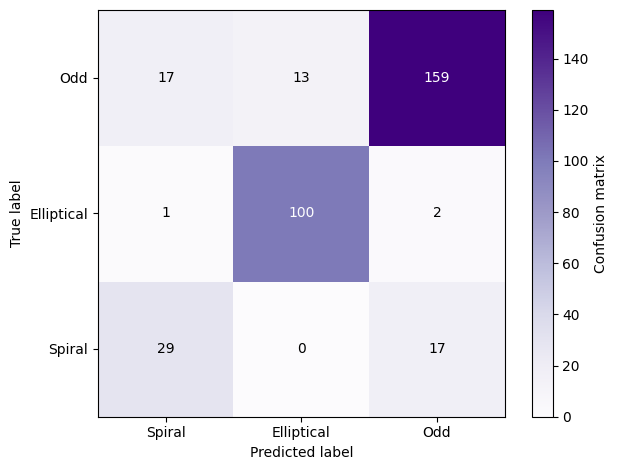

In [ ]:
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test_bad, y_pred_bad, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)

To compare the performace of classifier with the random classifier, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

In [ ]:
y_score_bad = gz2_training_model.predict_proba(X_test_bad)  # Use predicted probabilities for ROC curve
y_test_bin_bad = label_binarize(y_test_bad, classes=list(range(3)))  # Binarize the true labels

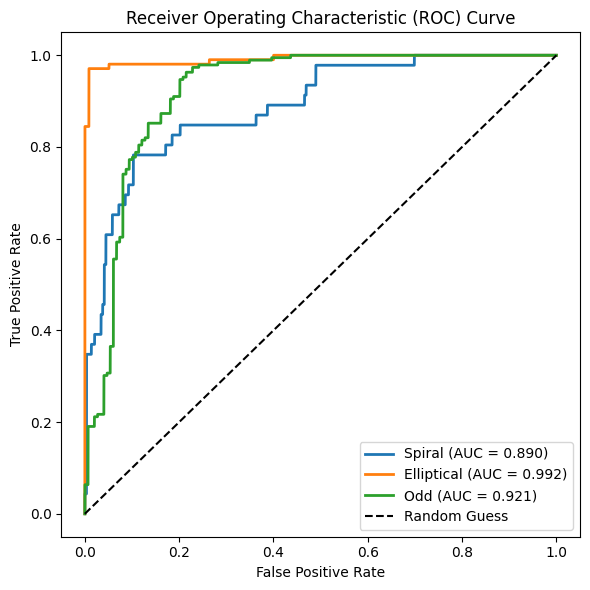

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_bad[:, i], y_score_bad[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))

# Save ROC curves
model_i_roc_curves = []

for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_i_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves = {}
roc_curves['Model I'] = model_i_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test_bad, y_pred_bad, average= 'weighted')
precision = precision_score(y_test_bad, y_pred_bad, average= 'weighted')
f1 = f1_score(y_test_bad, y_pred_bad, average= 'weighted')
accuracy = accuracy_score(y_test_bad, y_pred_bad)

cm = confusion_matrix(y_test_bad, y_pred_bad)

# Performance metrics (per-class)
recall_per_class = recall_score(y_test, y_pred_bad, average=None)
precision_per_class = precision_score(y_test, y_pred_bad, average=None)
f1_per_class = f1_score(y_test, y_pred_bad, average=None)
accuracy = accuracy_score(y_test, y_pred_bad) # overall

# Compute per-class TSS
tss_per_class = {}
for i, class_name in enumerate(['Spiral', 'Elliptical', 'Odd']):
  tp = cm[i, i]
  fn = np.sum(cm[i, :]) - tp
  fp = np.sum(cm[:, i]) - tp
  tn = np.sum(cm) - (tp + fn + fp)
  tss_per_class[class_name] = (tp / (tp + fn + 1e-6)) - (fp / (fp + tn + 1e-6))

# Store metrics in a list
metrics_list = []
metrics_list.append({'Recall per Class': recall_per_class,'Precision per Class': precision_per_class,'F1 per Class': f1_per_class, 'Accuracy': accuracy, 'TSS per Class': tss_per_class})

for result in metrics_list:
    print(result)

{'Recall per Class': array([0.19607843, 0.32978723, 0.52849741]), 'Precision per Class': array([0.21276596, 0.27433628, 0.57303371]), 'F1 per Class': array([0.20408163, 0.29951691, 0.54986523]), 'Accuracy': 0.4230769230769231, 'TSS per Class': {'Spiral': np.float64(0.5687909334982627), 'Elliptical': np.float64(0.9155546282810384), 'Odd': np.float64(0.7137530591510055)}}


### **Model II: 1D CNN + ZMs**

We go through the same steps as before.

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
# Splitting into train and test sets
X_train_bad, X_test_bad, y_train_bad, y_test_bad, train_indices, test_indices = train_test_split(all_zm_data_bad, all_labels_bad, np.arange(len(all_labels_bad)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded_bad = to_categorical(y_train_bad, num_classes=3)

In [ ]:
class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}

Due to the one dimensional structure of ZMs, we used a one dimentional achitecture for the CNN:

In [ ]:
# Building the model

# input value
x = Input(shape=(all_zm_data.shape[1],1))

c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(d2)

# output
de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)

de2 = Dense(3, activation='softmax')(de1)


model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_zm_45_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,763 (772.51 KB)

 Trainable params: 196,867 (769.01 KB)

 Non-trainable params: 896 (3.50 KB)

- The **1D CNN** model uses EarlyStopping as a callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True) # Callback Function

b_size = 64
e_num = 30

history = model.fit(
X_train, y_train_encoded,
batch_size=b_size,
epochs=e_num,
class_weight=class_weights,
verbose = 1,
callbacks=es,
validation_split=0.1)

#added restore_best_weights=True to the earlyStopping, so that it picks the best weights!

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.4769 - loss: 1.0245 - val_accuracy: 0.5098 - val_loss: 4.2369
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6757 - loss: 0.6677 - val_accuracy: 0.2059 - val_loss: 3.8568
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7097 - loss: 0.5260 - val_accuracy: 0.2843 - val_loss: 2.0317
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7602 - loss: 0.4996 - val_accuracy: 0.5294 - val_loss: 1.3118
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7634 - loss: 0.4708 - val_accuracy: 0.6471 - val_loss: 0.9069
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8225 - loss: 0.4116 - val_accuracy: 0.6373 - val_loss: 1.0165
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8263 - loss: 0.3659 - val_accuracy: 0.6471 - val_loss: 0.9914
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8110 - loss: 0.3548 - val_accuracy: 0.6078 

In [ ]:
y_pred_bad = model.predict(X_test_bad)
y_pred_labels_bad = np.argmax(y_pred_bad, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


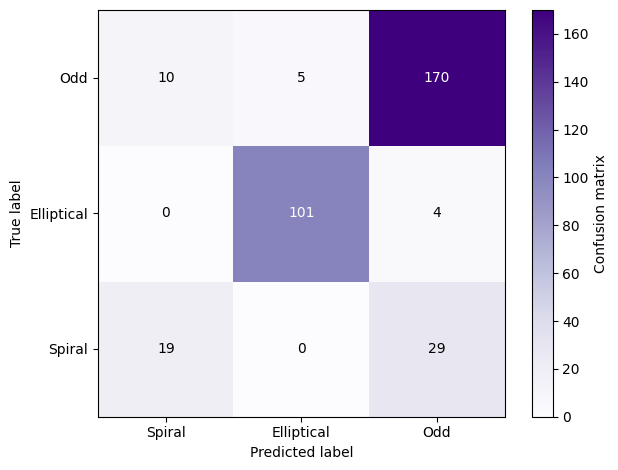

In [ ]:
# Plotting confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test_bad, y_pred_labels_bad, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)

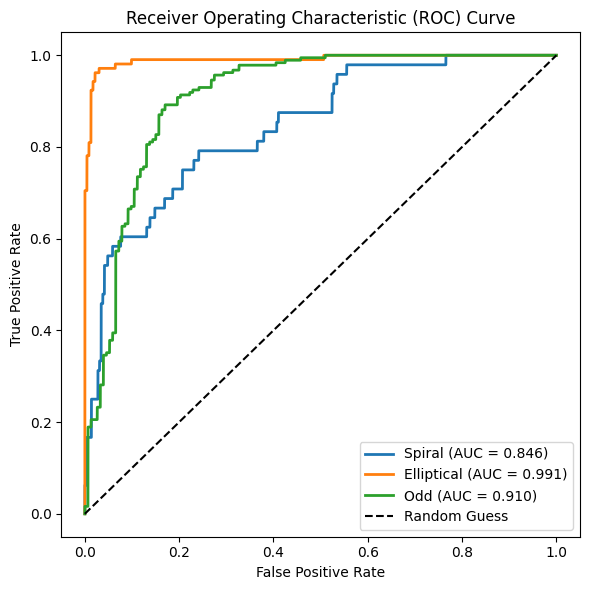

In [ ]:
# Plotting ROC curve
y_score_bad = y_pred_bad  # Use predicted probabilities for ROC curve
y_test_bin_bad = label_binarize(y_test_bad, classes=list(range(3)))  # Binarize the true labels

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_bad[:, i], y_score_bad[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


class_names = ['Spiral', 'Elliptical', 'Odd']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))

# Save ROC curves
model_ii_roc_curves = []

for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_ii_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model II'] = model_ii_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
precision = precision_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
f1 = f1_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
accuracy = accuracy_score(y_test_bad, y_pred_labels_bad)

cm = confusion_matrix(y_test_bad, y_pred_labels_bad)

tss_per_class = {}

#Performance metrics (per-class)
recall_per_class = recall_score(y_test, y_pred_labels_bad, average=None)
precision_per_class = precision_score(y_test, y_pred_labels_bad, average=None)
f1_per_class = f1_score(y_test, y_pred_labels_bad, average=None)
accuracy = accuracy_score(y_test, y_pred_labels_bad) # overall


for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements
    #added
    tss_per_class[class_name] = (tp / (tp + fn + 1e-6)) - (fp / (fp + tn + 1e-6))

metrics_list = []
metrics_list.append({'Recall per Class': recall_per_class,'Precision per Class': precision_per_class,'F1 per Class': f1_per_class, 'Accuracy': accuracy, 'TSS per Class': tss_per_class})

for result in metrics_list:
    print(result)

{'Recall per Class': array([0.04651163, 0.29347826, 0.59605911]), 'Precision per Class': array([0.06896552, 0.25471698, 0.59605911]), 'F1 per Class': array([0.05555556, 0.27272727, 0.59605911]), 'Accuracy': 0.4437869822485207, 'TSS per Class': {'Spiral': np.float64(0.3613505665850222), 'Elliptical': np.float64(0.9404455253680528), 'Odd': np.float64(0.7032326408517)}}


## **Models III, IV, and V**: Three classifier models based on the original images

For these models, a Vision Transformer was used as a data augmentation tool on the Galaxy and Non-Galaxy images.

*Note: The additional dependencies needed for these models (like Torch) have already been imported at the beginning of this notebook.*

To read the images of each class and convert to Pillow images we used the following function (Ghaderi et al., 2025):

In [ ]:
def load_galaxy_images(data_dir, target_size):
    """
    Loads, resizes, and processes all JPG images from the specified directory.

    Parameters:
    data_dir (str): The directory containing the JPG images to be processed.
    target_size (tuple): The target size for resizing the images, specified as (width, height).

    Returns:
    list: A list of PIL Image objects, each representing a resized and processed image.

    The function performs the following steps:
    1. Lists all JPG image files in the specified directory.
    2. Reads each image using OpenCV.
    3. Resizes each image to the specified target size.
    4. Scales the pixel values and converts the image to a format compatible with PIL.
    5. Converts each resized image to a PIL Image object.
    6. Appends each PIL Image object to a list.
    7. Returns the list of PIL Image objects.
    """

    all_images = []

    file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

    # Wrap the loop with tqdm to show progress
    for img in tqdm(file_path, desc="Processing images", unit="image"):
        image = cv2.imread(img)
        resized_image = cv2.resize(image, target_size)
        resized_image = (resized_image * 255).astype(np.uint8)
        pil_image = Image.fromarray(resized_image)
        all_images.append(pil_image)

    return all_images


The directories of Spiral, Elliptical, Odd objects images:

> Spiral: /repository/Data/galaxy/image/cropped_spiral
>
> Elliptical: /repository/Data/galaxy/image/cropped_elliptical
>
> Odd Objects: /repository/Data/galaxy/image/cropped_odd

In [ ]:
sp_dir = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/spiral_cropped'
el_dir = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/elliptical_cropped'
odd_dir = '/content/drive/Shared drives/DLP Project/Project/GZ2_thresholds/Data_85_90_newalg/odd_cropped'

image_size = 200

sp_img = load_galaxy_images(sp_dir, target_size=(image_size,image_size))
el_img = load_galaxy_images(el_dir, target_size=(image_size,image_size))
odd_img = load_galaxy_images(odd_dir, target_size=(image_size,image_size))

all_data = sp_img + el_img + odd_img
np.shape(all_data)

Processing images: 100%|██████████| 781/781 [00:08<00:00, 96.41image/s] 


(1351, 200, 200, 3)

In [ ]:
sp_dir_bad = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_spiral'
el_dir_bad = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_elliptical'
odd_dir_bad = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_odd'
image_size = 200

sp_img_bad = load_galaxy_images(sp_dir_bad, target_size=(image_size,image_size))
el_img_bad = load_galaxy_images(el_dir_bad, target_size=(image_size,image_size))
odd_img_bad = load_galaxy_images(odd_dir_bad, target_size=(image_size,image_size))

sp_img_bad = sp_img_bad[:196]
el_img_bad = el_img_bad[:374]
odd_img_bad = odd_img_bad[:781]

all_data_bad = sp_img_bad + el_img_bad + odd_img_bad
np.shape(all_data)

Processing images: 100%|██████████| 1528/1528 [00:20<00:00, 73.96image/s] 


(1351, 200, 200, 3)

We define the **vision transformer** for both training and testing data sets:

In [ ]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

### **Model III: CNN + Vision Transformer + Original Images**

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
# Splitting into train and test sets
X_train_bad, X_test_bad, y_train_bad, y_test_bad, train_indices, test_indices = train_test_split(all_data_bad, all_labels_bad, np.arange(len(all_labels_bad)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded_bad = to_categorical(y_train_bad, num_classes=3)

In [ ]:
transformed_X_train = []
for i in tqdm(range(len(X_train)), desc="Transforming Training Data"):
    transformed_train_images = train_transform(X_train[i])
    new_image = np.transpose(transformed_train_images, (1, 2, 0))
    transformed_X_train.append(new_image)

# Transformer for testing data with tqdm
transformed_X_test_bad = []
for j in tqdm(range(len(X_test_bad)), desc="Transforming Testing Data"):
    transformed_test_images_bad = test_transform(X_test_bad[j])
    new_images_bad = np.transpose(transformed_test_images_bad, (1, 2, 0))
    transformed_X_test_bad.append(new_images_bad)

Transforming Testing Data: 100%|██████████| 338/338 [00:00<00:00, 1215.09it/s]


In [ ]:
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [ ]:
# Building the model

# input
x = Input(shape=(image_size,image_size,3))

c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.1)(m2)


f = Flatten()(m2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(3, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_transformer_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 200, 200, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940,035 (11.22 MB)

 Trainable params: 2,939,139 (11.21 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Training the model
b_size = 64
e_num = 30

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4115 - loss: 4.5035 - val_accuracy: 0.2157 - val_loss: 8.7816
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - accuracy: 0.4545 - loss: 0.9883 - val_accuracy: 0.1765 - val_loss: 3.4022
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - accuracy: 0.5522 - loss: 0.8723 - val_accuracy: 0.4020 - val_loss: 1.8018
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accuracy: 0.6572 - loss: 0.6486 - val_accuracy: 0.6176 - val_loss: 1.3086
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accuracy: 0.6726 - loss: 0.6297 - val_accuracy: 0.5686 - val_loss: 1.0808
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.6551 - loss: 0.6876 - val_accuracy: 0.5392 - val_loss: 1.1010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.7134 - loss: 0.5946 - val_accuracy: 0.5098 - val_loss: 0.9272
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.6692 - loss: 0.6393 - val_accuracy:

In [ ]:
y_pred_bad = model.predict(np.array(transformed_X_test_bad))
y_pred_labels_bad = np.argmax(y_pred_bad, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step


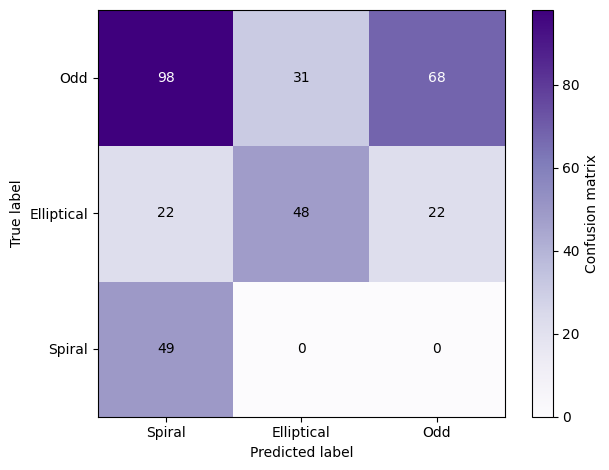

In [ ]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test_bad, y_pred_labels_bad, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)

In [ ]:
# Computing the ROC Curve
y_score = y_pred_bad
y_test_bin_bad = label_binarize(y_test_bad, classes=list(range(3)))  # Binarize the true labels

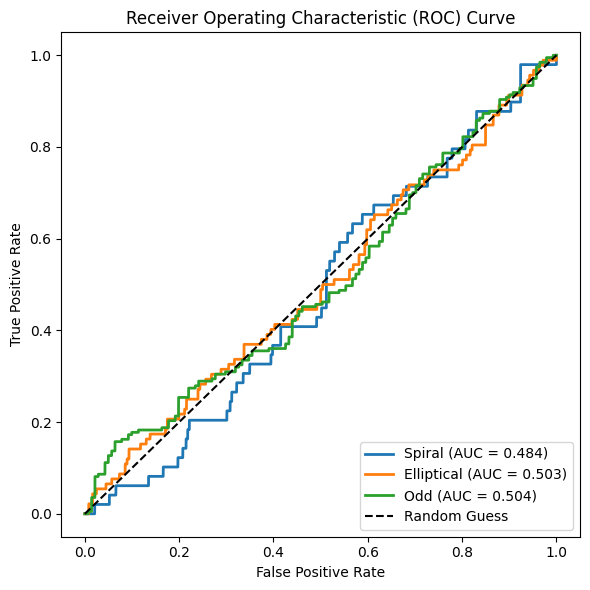

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_bad[:, i], y_score_bad[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))
# Save ROC curves
model_iii_roc_curves = []


for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_iii_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model III'] = model_iii_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
precision = precision_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
f1 = f1_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
accuracy = accuracy_score(y_test_bad, y_pred_labels_bad)

cm = confusion_matrix(y_test_bad, y_pred_labels_bad)

recall_per_class = recall_score(y_test, y_pred_labels_bad, average=None)
precision_per_class = precision_score(y_test, y_pred_labels_bad, average=None)
f1_per_class = f1_score(y_test, y_pred_labels_bad, average=None)
accuracy = accuracy_score(y_test, y_pred_labels_bad) #overall


for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements
    tss_per_class[class_name] = (tp / (tp + fn + 1e-6)) - (fp / (fp + tn + 1e-6))

# Store metrics in a list
metrics_list = []
metrics_list.append({'Recall per Class': recall_per_class,'Precision per Class': precision_per_class,'F1 per Class': f1_per_class, 'Accuracy': accuracy, 'TSS per Class': tss_per_class})

# Print final metrics
for result in metrics_list:
    print(result)

{'Recall per Class': array([0.54166667, 0.26530612, 0.328125  ]), 'Precision per Class': array([0.15384615, 0.32911392, 0.7       ]), 'F1 per Class': array([0.23963134, 0.29378531, 0.44680851]), 'Accuracy': 0.34023668639053256, 'TSS per Class': {'Spiral': np.float64(0.5847750675337919), 'Elliptical': np.float64(0.3957228651133648), 'Odd': np.float64(0.18914929553470633)}}


### **Model IV: ResNet50 + Vision transformer + Original Images**

In [ ]:
# Splitting into train and test sets
X_train_bad, X_test_bad, y_train_bad, y_test_bad, train_indices_bad, test_indices_bad = train_test_split(all_data_bad, all_labels_bad, np.arange(len(all_labels_bad)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded_bad = to_categorical(y_train_bad, num_classes=3)

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test_bad=[]
for j in range(len(X_test_bad)):
  transformed_test_images_bad = test_transform(X_test_bad[j])
  new_images_bad = np.transpose(transformed_test_images_bad, (1, 2, 0))
  transformed_X_test_bad.append(new_images_bad)

In [ ]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [ ]:
# Defining the pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(3, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.5256 - loss: 7.8395 - val_accuracy: 0.2255 - val_loss: 262426.9688
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - accuracy: 0.6093 - loss: 0.7463 - val_accuracy: 0.1471 - val_loss: 1.0987
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - accuracy: 0.7531 - loss: 0.4811 - val_accuracy: 0.6275 - val_loss: 1.0976
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - accuracy: 0.7979 - loss: 0.4379 - val_accuracy: 0.6275 - val_loss: 1.0966
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.9120 - loss: 0.2259 - val_accuracy: 0.6078 - val_loss: 0.9613
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.9324 - loss: 0.1735 - val_accuracy: 0.2745 - val_loss: 1.5669
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - accuracy: 0.8867 - loss: 0.2756 - val_accuracy: 0.5196 - val_loss: 8.6130
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.9458 - loss: 0.1902 - val_accur

In [ ]:
y_pred_bad = model.predict(np.array(transformed_X_test_bad))
y_pred_labels_bad = np.argmax(y_pred_bad, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step


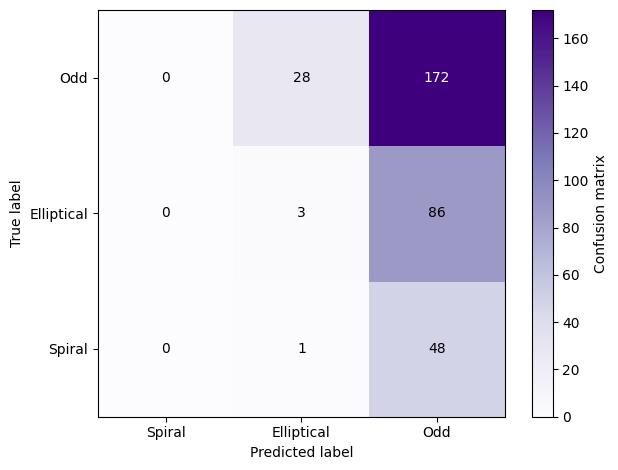

In [ ]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test_bad, y_pred_labels_bad, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)

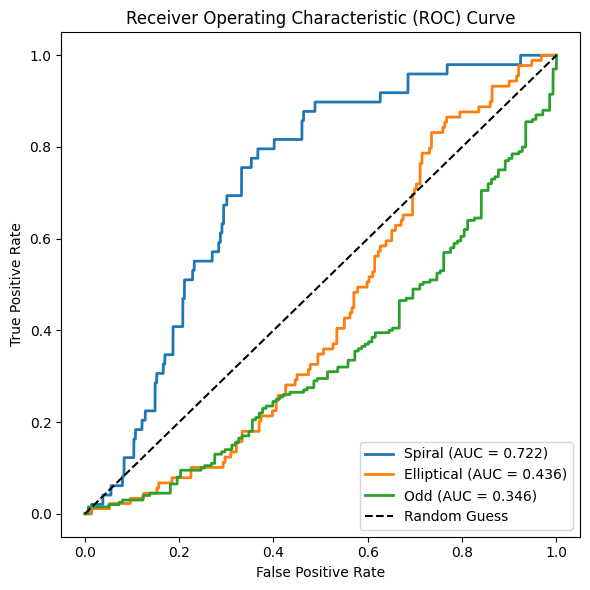

In [ ]:
# Plotting ROC curve
y_score_bad = y_pred_bad
y_test_bin_bad = label_binarize(y_test_bad, classes=list(range(3)))  # Binarize the true labels

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_bad[:, i], y_score_bad[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))

# Save ROC curves
model_iv_roc_curves = []

for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_iv_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model IV'] = model_iv_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
precision = precision_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
f1 = f1_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
accuracy = accuracy_score(y_test_bad, y_pred_labels_bad)

cm = confusion_matrix(y_test_bad, y_pred_labels_bad)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Spiral' class: 0.0
TSS for 'Elliptical' class: -0.08275799828527594
TSS for 'Odd' class: -0.11101449275362318


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.5177514792899408
Precision: 0.35728417353134545
F1_score: 0.4153301851690419
Accuracy: 0.5177514792899408
TSS: -0.11101449275362318


### **Model V: VGG16 + Vision Transformer + Original Images**

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
# Splitting into train and test sets
X_train_bad, X_test_bad, y_train_bad, y_test_bad, train_indices_bad, test_indices_bad= train_test_split(all_data_bad, all_labels_bad, np.arange(len(all_labels_bad)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded_bad= to_categorical(y_train_bad, num_classes=3)

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test_bad=[]
for j in range(len(X_test_bad)):
  transformed_test_images_bad = test_transform(X_test_bad[j])
  new_images_bad = np.transpose(transformed_test_images_bad, (1, 2, 0))
  transformed_X_test_bad.append(new_images_bad)

In [ ]:
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [ ]:
# Defining the pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.2995 - loss: 2.0783 - val_accuracy: 0.5882 - val_loss: 1.0484
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 722ms/step - accuracy: 0.5196 - loss: 1.0968 - val_accuracy: 0.2059 - val_loss: 1.0840
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.2802 - loss: 1.0899 - val_accuracy: 0.1961 - val_loss: 1.0992
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 700ms/step - accuracy: 0.2537 - loss: 1.0761 - val_accuracy: 0.1961 - val_loss: 1.0991
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 0.3144 - loss: 1.1068 - val_accuracy: 0.5294 - val_loss: 1.0926
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 725ms/step - accuracy: 0.3664 - loss: 1.0950 - val_accuracy: 0.5980 - val_loss: 0.9901
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.4214 - loss: 1.1175 - val_accuracy: 0.1961 - val_loss: 1.1002
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.2817 - loss: 1.0751 - val_accura

In [ ]:
y_pred_bad = model.predict(np.array(transformed_X_test_bad))
y_pred_labels_bad = np.argmax(y_pred_bad, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 803ms/step


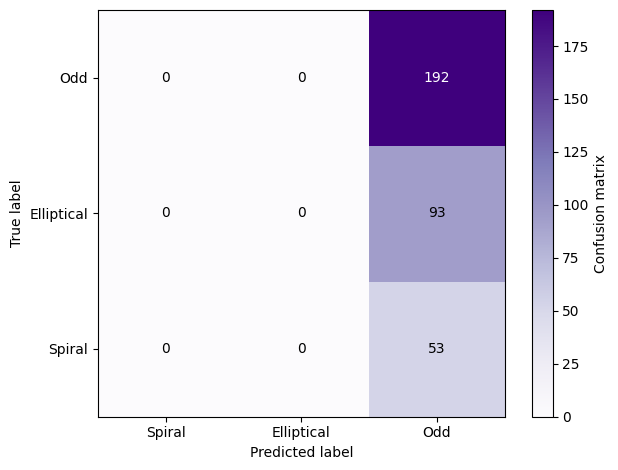

In [ ]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test_bad, y_pred_labels_bad, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)

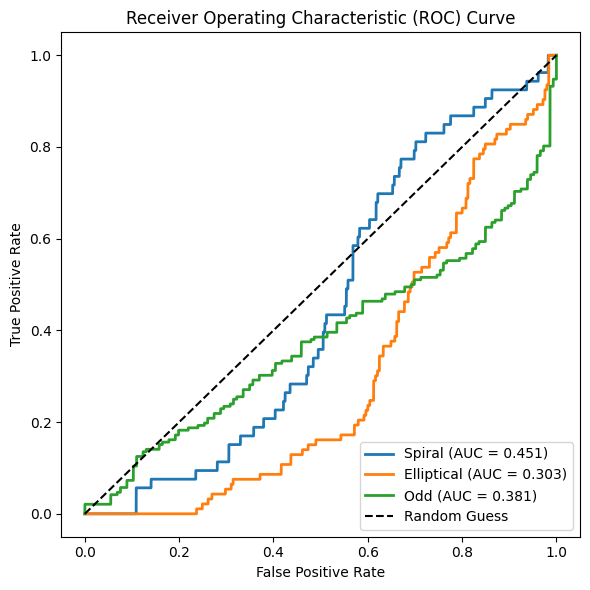

In [ ]:
# Plotting ROC curve
y_score_bad = y_pred_bad
y_test_bin_bad = label_binarize(y_test_bad, classes=list(range(3)))  # Binarize the true labels

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_bad[:, i], y_score_bad[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))
# Save ROC curves
model_v_roc_curves = []


for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_v_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model V'] = model_v_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
precision = precision_score(y_test_bad, y_pred_labels_bad, average= 'weighted')
f1 = f1_score(y_test_bad, y_pred_labels_bad, average= 'weighted')

accuracy = accuracy_score(y_test_bad, y_pred_labels_bad)

cm = confusion_matrix(y_test_bad, y_pred_labels_bad)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Spiral' class: 0.0
TSS for 'Elliptical' class: 0.0
TSS for 'Odd' class: 0.0


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.5680473372781065
Precision: 0.3226777773887469
F1_score: 0.41156637266942053
Accuracy: 0.5680473372781065
TSS: 0.0


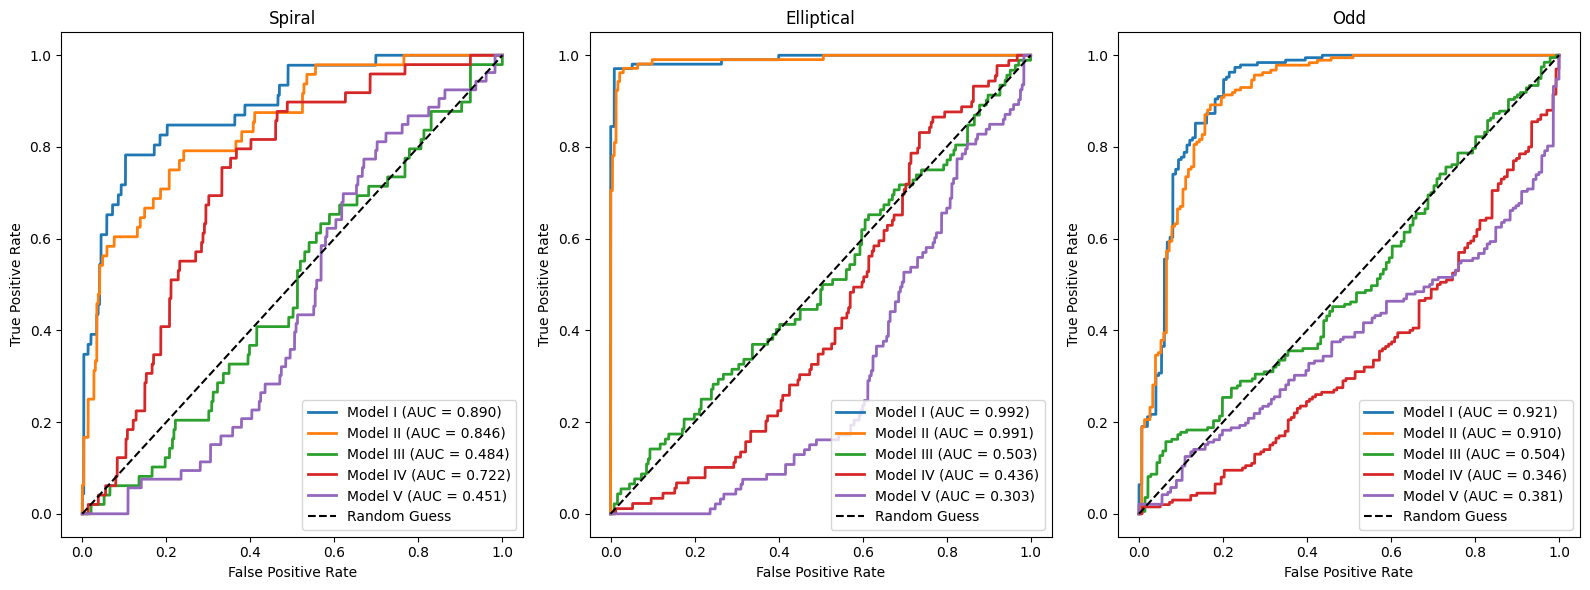

In [ ]:
# ROC Curves for Spiral Galaxy
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

# Iterate over classes
classes = ['Spiral', 'Elliptical', 'Odd']
for i, class_name in enumerate(classes):

  # Iterate over models
  for model_name in roc_curves:

    # Get the i-th class ROC curves of the current model
    class_roc_curves = roc_curves[model_name][i]

    # ROC curve data of i-th class by the current model
    mean_fpr = class_roc_curves[0]
    mean_tpr = class_roc_curves[1]
    mean_auc = class_roc_curves[2]

    ax[i].plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=2)

  ax[i].plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

  ax[i].set_title(f'{class_name}')
  ax[i].set_xlabel('False Positive Rate')
  ax[i].set_ylabel('True Positive Rate')
  ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()